# DFE Inference
## Base inference
In order to infer the DFE of a single pair, one neutral and one selected, we can use {class}`~fastdfe.base_inference.BaseInference`. In this example we create {class}`~fastdfe.spectrum.Spectrum` objects holding the SFS counts and pass them to {class}`~fastdfe.base_inference.BaseInference`. Note that we are required to specify the number of monomorphic sites (the last and first entries of the specified counts).

In [3]:
library(fastdfe)

In [4]:
# load the fastdfe package
fastdfe <- load_fastdfe()

In [5]:
# import classes
BaseInference <- fastdfe$BaseInference
Spectrum <- fastdfe$Spectrum

sfs_neut <- Spectrum(c(177130, 997, 441, 228, 156, 117, 114, 83, 105, 109, 652))
sfs_sel <- Spectrum(c(797939, 1329, 499, 265, 162, 104, 117, 90, 94, 119, 794))

# create inference object
inf <- BaseInference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel,
    n_runs = 10
)

# run inference
sfs_modelled <- BaseInference$run(inf)


fastDFE uses maximum likelihood estimation (MLE) to find the DFE. By default, 10 local optimization runs are carried out to make sure a reasonably good global optimum has been bound (see {class}`~fastdfe.base_inference.BaseInference` for all configuration options). The DFE furthermore needs to parametrized where {class}`~fastdfe.parametrization.GammaExpParametrization` is used by default.

We can now plot the inferred DFE in discretized form (cf. {func}`~fastdfe.base_inference.BaseInference.plot_discretized`).

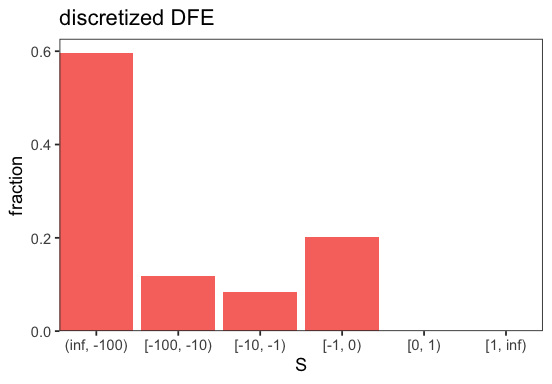

In [6]:
p <- BaseInference$plot_discretized(inf)

We can also plot a comparison of the (selected) modelled and observed SFS (cf. {func}`~fastdfe.base_inference.BaseInference.plot_sfs_comparison`).

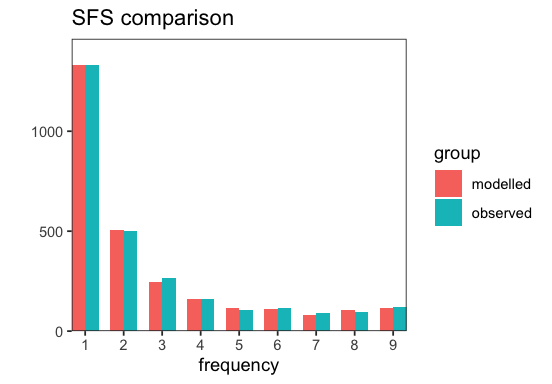

In [7]:
p <- BaseInference$plot_sfs_comparison(inf);

### Bootstrapping

We can perform parametric bootstrapping (cf. {func}`~fastdfe.base_inference.BaseInference.bootstrap`) to estimate the uncertainty of the inferred DFE. This is done by sampling new SFSs from the inferred DFE and re-running the inference.

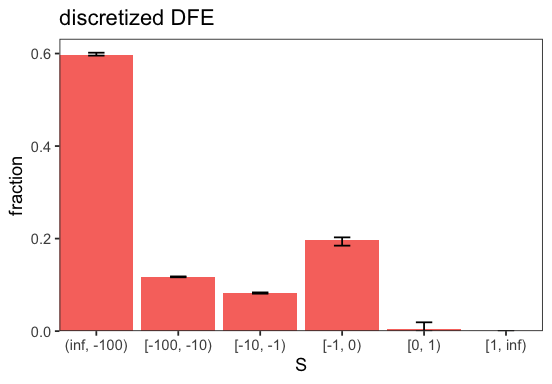

In [8]:
# run bootstrapping
bootstraps <- BaseInference$bootstrap(inf, n_samples = 100)

# redo the plotting
p <- BaseInference$plot_discretized(inf)

The bars indicate 95% confidence intervals. We can adjust the confidence level among other things (cf. {func}`~fastdfe.base_inference.BaseInference.plot_discretized`).

### Fixing parameters
We can hold parameters fixed during the maximum likelihood optimization. This is useful, for example, if only using a subset of the parameters has a reasonable interpretation. In this example, we fix ancestral-allele mis-identification rate ``eps`` to 0. We also force the DFE to be purely deleterious, by fixing ``S_b`` to some arbitrary value and setting ``p_b`` to 0 (cf. {class}`~fastdfe.parametrization.GammaExpParametrization`).

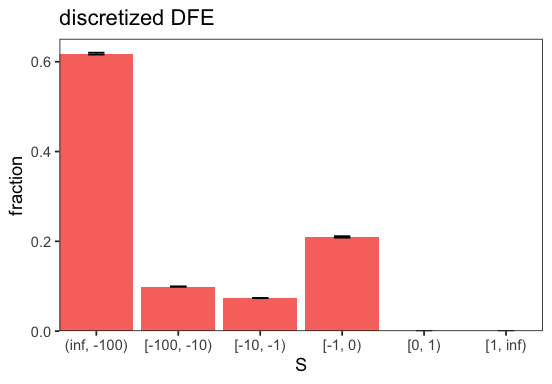

In [9]:
# create inference object
inf <- BaseInference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel,
    # Fix parameters, note that we need specify type 'all'
    # if only one type is used. Later we will work with
    # more than one type.
    fixed_params = list(all=list(eps=0, S_b=1, p_b=0)),
    do_bootstrap = TRUE
)

# run inference
sfs_modelled <- BaseInference$run(inf)

p <- BaseInference$plot_discretized(inf);

### Nested model comparison
We can automatically check for the significance of include ancestral-allele mis-identification and beneficial fitness affects using likelihood ratio test (LRTs). This is done with {func}`~fastdfe.base_inference.BaseInference.plot_nested_models`. The LRTs are performed by comparing the likelihood of the inferred DFE to the likelihood of a nested model where some parameters are held fixed.

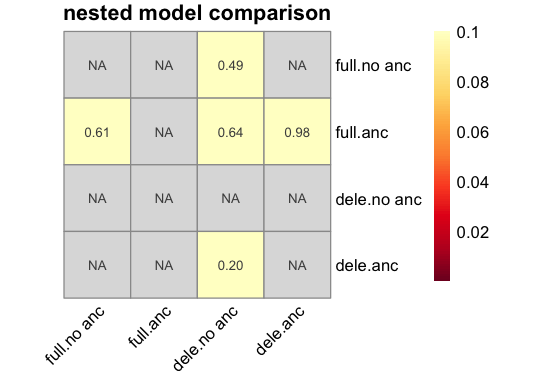

In [10]:
p <- BaseInference$plot_nested_models(inf)

Neither including beneficial mutations nor ancestral-allele mis-identification do appear to improve the fit significantly.

### Visualize likelihoods
We can visualize the likelihoods of the differently-initialized optimization runs. This can give us some information on how good an optimum could be found.

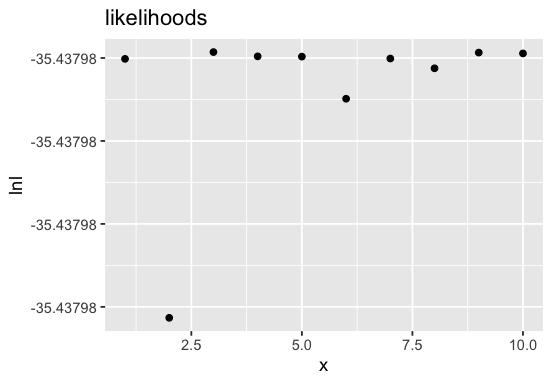

In [11]:
p <- BaseInference$plot_likelihoods(inf, scale = 'lin')

There might be some room for improvement as the likelihoods do show some variation. We could consider increasing the ``n_runs`` argument.

### Serialization

In [12]:
# save the inference object to a file
# unserialize with BaseInference$from_file
BaseInference$to_file(inf, "serialized.json")

# we can also save a short summary to fa ile
BaseInference$get_summary(inf)$to_file("summary.json")

## Folded inference
To infer the DFE from a folded SFS, simply pass folded spectra to {class}`~fastdfe.base_inference.BaseInference`. Folded inference is performed whenever the spectra appear to be folded, i.e., when all entries where the derived allele is the major allele are zero. In this example, we only infer the deleterious DFE as folded spectra contain no information on beneficial mutations.

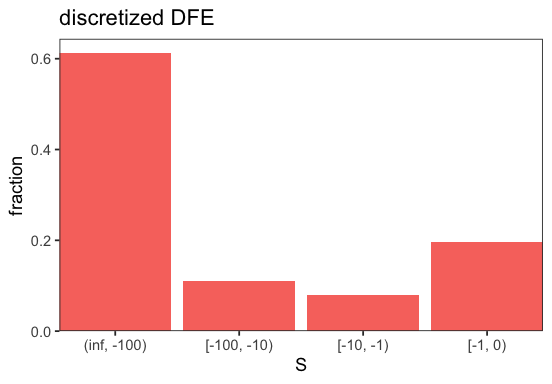

In [13]:
# create inference object
inf <- BaseInference(
    sfs_neut = Spectrum$fold(sfs_neut),
    sfs_sel = Spectrum$fold(sfs_sel),
    fixed_params = list(all = list(eps = 0, S_b = 1, p_b = 0))
)

# run inference
sfs_modelled <- BaseInference$run(inf)

p <- BaseInference$plot_discretized(inf, intervals = c(-Inf, -100, -10, -1, 0))

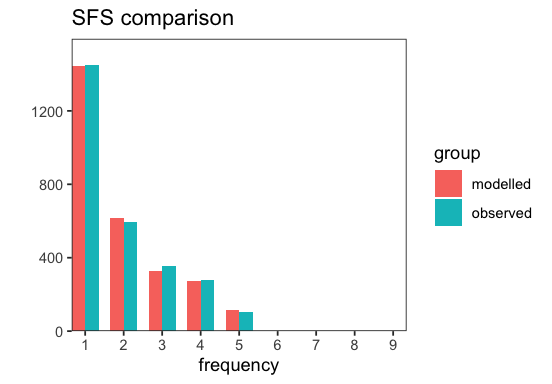

In [14]:
p <- BaseInference$plot_sfs_comparison(inf)

## Joint inference
fastDFE supports joint inference of several SFS types, where any parameters can be shared between types. In this example, we create a {class}`~fastdfe.joint_inference.JointInference` object with two types, where we share ``eps``, the rate of ancestral misidentification and ``S_d``, the mean selection coefficient for deleterious mutations (cf. {class}`~fastdfe.parametrization.GammaExpParametrization`). For more complex stratifications, see the {class}`~fastdfe.parser.Parser`) module.

In [15]:
joint_inference <- fastdfe$JointInference
spectra <- fastdfe$Spectra
shared_params <- fastdfe$SharedParams

# neutral SFS for two types
sfs_neut <- spectra(list(
    pendula = c(177130, 997, 441, 228, 156, 117, 114, 83, 105, 109, 652),
    pubescens = c(172528, 3612, 1359, 790, 584, 427, 325, 234, 166, 76, 31)
))

# selected SFS for two types
sfs_sel <- spectra(list(
    pendula = c(797939, 1329, 499, 265, 162, 104, 117, 90, 94, 119, 794),
    pubescens = c(791106, 5326, 1741, 1005, 756, 546, 416, 294, 177, 104, 41)
))

# create inference object
inf <- joint_inference(
    sfs_neut = sfs_neut,
    sfs_sel = sfs_sel,
    shared_params = list(shared_params(types = c("pendula", "pubescens"), params = c("eps", "S_d"))),
    do_bootstrap = TRUE
)

# run inference
sfs_modelled <- joint_inference$run(inf)

{class}`~fastdfe.joint_inference.JointInference` both runs the joint inference and marginal inference where each type is inferred separately. To see this better we can plot the inferred parameters for the different inference types.

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


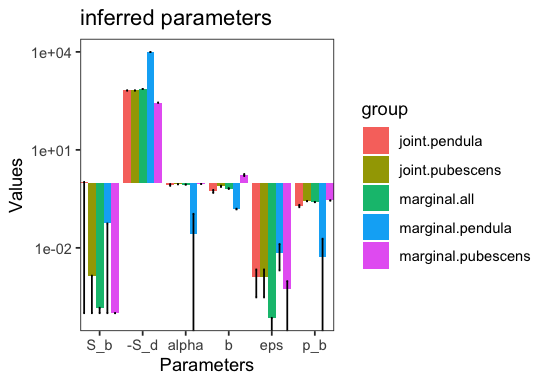

In [16]:
p <- joint_inference$plot_inferred_parameters(inf)

``marginal.pendula`` and ``marginal.pubescens`` are the marginal inferences for the respective type. ``marginal.all`` is the marginal inference obtaining by adding up the spectra of all types. ``joint.pendula`` and ``join.pubescens`` are the joint inferences for the respective type. We can see that ``eps`` and ``S_d`` are indeed shared between the two. The parameter ``alpha`` in the plot denotes the proportion of beneficial non-synonymous substitutions. Each marginal inference is a {class}`~fastdfe.base_inference.BaseInference` object itself and can be accessed via ``inf.marginal_inferences[type]``.

We can now also investigate to what extent the inferred DFEs differ:

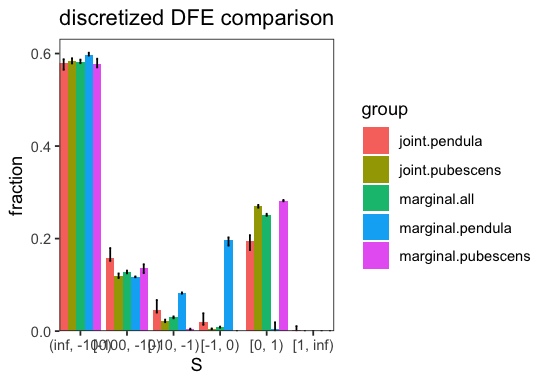

In [17]:
p <- joint_inference$plot_discretized(inf)

### Model comparison
We can obtain information about the goodness of fit achieved by sharing the parameter by performing a likelihood ratio test (cf. {func}`~fastdfe.joint_inference.JointInference.perform_lrt_shared`). This compares the likelihood of the joint inference with the product of the marginal likelihoods.

In [18]:
joint_inference$perform_lrt_shared(inf)

[1] 0.4529381

The test is not significant, indicating that the simpler model of sharing the parameters explains the data sufficiently well. Indeed, we do not observe a lot of differences between the inferred parameters of joint and the marginal inferences.

## Covariates
{class}`~fastdfe.joint_inference.JointInference` also supports the inclusion of covariates associates with the different SFS types. This provides more powerful model testing and reduces the number of parameters that need to be estimated for the joint inference. For a more interesting example we stratify the SFS of `B. pendula` by the sites' reference base as is described in more detail in the {mod}`~fastdfe.parser` module.

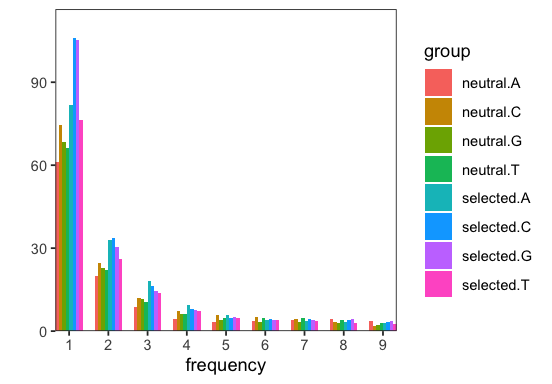

In [19]:
parser <- fastdfe$Parser
spectra <- fastdfe$Spectra

# instantiate parser
p <- parser(
    n = 10,
    vcf = paste0(
        "https://github.com/Sendrowski/fastDFE/",
        "blob/dev/resources/genome/betula/",
        "all.polarized.deg.subset.200000.vcf.gz?raw=true"
    ),
    stratifications = list(fastdfe$DegeneracyStratification(), fastdfe$AncestralBaseStratification())
)

# parse SFS
s <- parser$parse(p)

# visualize spectra
p <- spectra$plot(s)

We now create the inference object from the spectra. In this contrived example we make up some covariates that covary with ``S_d``, the mean strength of negative selection. Covariates introduce a linear relationship by default but this can be modified by specifying a custom callback function (see {class}`~fastdfe.optimization.Covariate`).

In [20]:
covariate <- fastdfe$Covariate

# create inference object
inf <- joint_inference(
    sfs_neut = s$select('neutral.*')$merge_groups(1),
    sfs_sel = s$select('selected.*')$merge_groups(1),
    covariates = list(covariate(param = 'S_d', values = list(A = 1, C = 2, T = 3, G = 4))),
    fixed_params = list(all = list(S_b = 1, eps = 0, p_b = 0)),
    do_bootstrap = TRUE
)

# run inference
sfs_modelled <- joint_inference$run(inf)

Let's visualize the inferred parameters

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


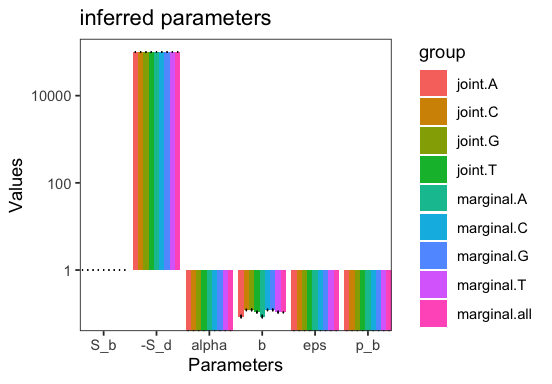

In [21]:
p <- joint_inference$plot_inferred_parameters(inf)

We see that ``S_d`` does not vary markedly across the jointly-inferred types and this is because it does not vary linearly along the arbitrary covariates we specified. Indeed, looking at the mean over all bootstraps for our covariate we see that it is close to 0. Note that covariates are named ``c0``, ``c1``, etc. by default.

In [22]:
mean(inf$bootstraps[['A.c0']])

[1] 1.428936e-07

### Model comparison
We can perform a likelihood ratio test to see whether including the covariates produces a significantly better fit than simply sharing the parameter in question among the types (cf. {func}`~fastdfe.joint_inference.JointInference.perform_lrt_covariates`).

In [23]:
joint_inference$perform_lrt_covariates(inf)

[1] 1

As expected, the specified covariates do not improve the fit significantly.